In [1]:
# pip install pandas  matplotlib seaborn statsmodels

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
mmm_data = pd.read_csv('MMM_Data_synthetic_modified.csv')

In [4]:
mmm_data

,week_start,week_end,week_number,year_number,partner_count,Promo,Natural Search Visits,competitor_change_flag,channel 0_spend,channel 0_clicks,...,Channel 11_spend,Channel 11_clicks,Channel 11_impressions,Channel 12_spend,Channel 12_clicks,Channel 12_impressions,Channel 13_spend,Channel 13_clicks,Channel 13_impressions,Subscriptions
0,6/27/2022,7/3/2022,27,2022,13,0,29985.60969,0,1111.144573,914.198687,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200.164442
1,7/4/2022,7/10/2022,28,2022,15,0,23840.52883,0,1404.464179,2159.410668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270.896178
2,7/11/2022,7/17/2022,29,2022,12,1,13563.34260,0,2744.381149,2842.643411,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,232.538114
3,7/18/2022,7/24/2022,30,2022,12,1,19861.37170,0,3493.213503,2637.664279,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,211.083653
4,7/25/2022,7/31/2022,31,2022,15,1,18001.94172,0,3507.389674,2797.310817,...,NaN,NaN,NaN,5153.713746,792.720714,1.911834e+04,NaN,NaN,NaN,238.647466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,9/1/2025,9/7/2025,36,2025,30,1,36307.93578,1,10389.694649,5890.396990,...,NaN,NaN,NaN,28166.097180,4353.539677,1.204826e+06,21992.566873,-584.609783,9.751352e+05,1554.034974
167,9/8/2025,9/14/2025,37,2025,19,0,34032.04096,1,7323.204534,3630.553165,...,NaN,NaN,NaN,20350.098174,4108.119791,8.665761e+05,18110.431148,1410.308144,1.403350e+06,1568.748258
168,9/15/2025,9/21/2025,38,2025,31,1,31364.20146,1,8553.947466,5996.407221,...,NaN,NaN,NaN,14876.060515,4108.692262,6.033883e+05,45469.049393,2608.884021,3.792378e+06,900.557577
169,9/22/2025,9/28/2025,39,2025,23,0,19834.82218,1,5389.465949,3445.008225,...,NaN,NaN,NaN,19211.046113,6397.868449,1.304002e+06,90457.619187,1872.853694,5.972885e+06,799.702279


### There are 16 channels with spend, click, impression information from June 2022 to September 2025.

### The data is at a weekly level. Going to check if the spend is increasing by media channels so that the MMM model can assign incremental effect to each of the media channels. Also will check the coverage of weeks by media channels. 

## `Goal`
### The goal of the project is to see which channel spend results in most conversion. The target variable is "Subscriptions".
### Going to model subscription by media channels based on spend. 

In [5]:
spend_cols = [c for c in mmm_data.columns if c.endswith('_spend')]

In [6]:
spend_cols

['channel 0_spend',
 'Channel 14_spend',
 'Channel 1_spend',
 'Channel 2_spend',
 'Channel 3_spend',
 'Channel 15_spend',
 'Channel 4_spend',
 'Channel 5_spend',
 'Channel 6_spend',
 'Channel 7_spend',
 'Channel 8_spend',
 'Channel 9_spend',
 'Channel 10_spend',
 'Channel 11_spend',
 'Channel 12_spend',
 'Channel 13_spend']

In [7]:
mmm_data_spend_long = mmm_data[spend_cols].melt(
    var_name = 'media_channel',
    value_name = 'spend'
)

In [8]:
mmm_data_spend_long['media_channel'] = mmm_data_spend_long['media_channel'].str.replace('_spend', '')
mmm_data_spend_long

,media_channel,spend
0,channel 0,1111.144573
1,channel 0,1404.464179
2,channel 0,2744.381149
3,channel 0,3493.213503
4,channel 0,3507.389674
...,...,...
2731,Channel 13,21992.566873
2732,Channel 13,18110.431148
2733,Channel 13,45469.049393
2734,Channel 13,90457.619187


In [9]:
mmm_data_spend_long

,media_channel,spend
0,channel 0,1111.144573
1,channel 0,1404.464179
2,channel 0,2744.381149
3,channel 0,3493.213503
4,channel 0,3507.389674
...,...,...
2731,Channel 13,21992.566873
2732,Channel 13,18110.431148
2733,Channel 13,45469.049393
2734,Channel 13,90457.619187


In [10]:
media_summary = (
    mmm_data_spend_long.groupby(['media_channel'])['spend']
    .agg(
        Min = 'min',
        Q10 = lambda x: x.quantile(0.10),
        Q25 = lambda x: x.quantile(0.25),
        Median = 'median',
        Q75 = lambda x: x.quantile(0.75),
        Q90 = lambda x: x.quantile(0.90),
        Max = 'max',
        Sum = 'sum',
        Average = 'mean'
    ).reset_index()
)

In [11]:
media_summary

,media_channel,Min,Q10,Q25,Median,Q75,Q90,Max,Sum,Average
0,Channel 1,8637.616566,9457.131654,11039.213555,11738.725263,24055.109903,29767.166049,45030.949102,1.669909e+05,18554.542425
1,Channel 10,3019.645750,7029.031423,12318.564158,16660.697559,23772.578253,42935.135223,83753.115579,1.323022e+06,21339.065061
2,Channel 11,12413.066639,25439.590111,44979.375320,52617.006364,70891.513311,80072.709914,86193.507650,2.670945e+05,53418.893857
3,Channel 12,628.866833,4033.403628,6926.683766,10941.285573,14978.618950,22755.885212,53517.797947,1.512381e+06,12099.049691
4,Channel 13,2430.980169,13811.040744,19330.788980,34967.710196,64064.408703,82069.942798,132581.992941,4.471629e+06,42996.434965
5,Channel 14,339.089152,1530.213593,2544.580476,3681.306745,7642.091061,9772.299803,28036.700512,4.732729e+05,5088.955895
6,Channel 15,1990.311438,5767.138107,9102.574334,17213.815551,33325.497750,45548.167689,90971.323793,3.873891e+06,22787.596226
7,Channel 2,168.464852,441.596131,747.634677,1002.501316,1895.167550,2489.712281,4426.765653,4.254468e+04,1372.408884
8,Channel 3,2985.231990,8130.435627,12007.363512,19042.496154,28718.226420,38902.260319,55419.884185,3.666575e+06,21441.956530
9,Channel 4,1266.481257,2156.332638,3491.109711,4458.028708,6113.391228,7105.410891,7766.757333,2.309577e+04,4619.153647


#### From the media summary above, good spread of the spend across media channels which will be helpful for calculating incremental effect from the MMM.

### Now to check the converage of the media channels. Meaning out of the 3.5 years, in how many weeks do each of the media channels have spend data. This will help to omit the media channels which do not have a lot of spending. 

In [12]:
mmm_data_spend_long_weeks = mmm_data.melt(
    id_vars = ['week_start'],
    value_vars = spend_cols,
    var_name = 'media_channel',
    value_name = 'spend'
)
mmm_data_spend_long_weeks

,week_start,media_channel,spend
0,6/27/2022,channel 0_spend,1111.144573
1,7/4/2022,channel 0_spend,1404.464179
2,7/11/2022,channel 0_spend,2744.381149
3,7/18/2022,channel 0_spend,3493.213503
4,7/25/2022,channel 0_spend,3507.389674
...,...,...,...
2731,9/1/2025,Channel 13_spend,21992.566873
2732,9/8/2025,Channel 13_spend,18110.431148
2733,9/15/2025,Channel 13_spend,45469.049393
2734,9/22/2025,Channel 13_spend,90457.619187


In [13]:
mmm_data_spend_long_weeks['media_channel'] =  mmm_data_spend_long_weeks['media_channel'].str.replace('_spend', '')
mmm_data_spend_long_weeks = mmm_data_spend_long_weeks[mmm_data_spend_long_weeks['spend'].notna() & (mmm_data_spend_long_weeks['spend'] > 0)]

week_counts = (
    mmm_data_spend_long_weeks.groupby('media_channel')['week_start']
    .count()
    .reset_index(name = 'unique_weeks_active')
)

In [14]:
week_counts

,media_channel,unique_weeks_active
0,Channel 1,9
1,Channel 10,62
2,Channel 11,5
3,Channel 12,125
4,Channel 13,104
5,Channel 14,93
6,Channel 15,170
7,Channel 2,31
8,Channel 3,171
9,Channel 4,5


Merging it back to media_summary

In [15]:
media_summary_weeks_active = media_summary.merge(week_counts, on = 'media_channel', how = 'left')
media_summary_weeks_active

,media_channel,Min,Q10,Q25,Median,Q75,Q90,Max,Sum,Average,unique_weeks_active
0,Channel 1,8637.616566,9457.131654,11039.213555,11738.725263,24055.109903,29767.166049,45030.949102,1.669909e+05,18554.542425,9
1,Channel 10,3019.645750,7029.031423,12318.564158,16660.697559,23772.578253,42935.135223,83753.115579,1.323022e+06,21339.065061,62
2,Channel 11,12413.066639,25439.590111,44979.375320,52617.006364,70891.513311,80072.709914,86193.507650,2.670945e+05,53418.893857,5
3,Channel 12,628.866833,4033.403628,6926.683766,10941.285573,14978.618950,22755.885212,53517.797947,1.512381e+06,12099.049691,125
4,Channel 13,2430.980169,13811.040744,19330.788980,34967.710196,64064.408703,82069.942798,132581.992941,4.471629e+06,42996.434965,104
5,Channel 14,339.089152,1530.213593,2544.580476,3681.306745,7642.091061,9772.299803,28036.700512,4.732729e+05,5088.955895,93
6,Channel 15,1990.311438,5767.138107,9102.574334,17213.815551,33325.497750,45548.167689,90971.323793,3.873891e+06,22787.596226,170
7,Channel 2,168.464852,441.596131,747.634677,1002.501316,1895.167550,2489.712281,4426.765653,4.254468e+04,1372.408884,31
8,Channel 3,2985.231990,8130.435627,12007.363512,19042.496154,28718.226420,38902.260319,55419.884185,3.666575e+06,21441.956530,171
9,Channel 4,1266.481257,2156.332638,3491.109711,4458.028708,6113.391228,7105.410891,7766.757333,2.309577e+04,4619.153647,5


by year summary

In [16]:
spend_cols = [c for c in mmm_data.columns if c.endswith('_spend')]

mmm_data_spend_year = mmm_data.melt(
    id_vars = ['year_number'],
    value_vars = spend_cols,
    var_name = 'media_spend',
    value_name = 'spend'
)

year_summary = (
    mmm_data_spend_year.groupby('year_number')['spend']
    .agg(
        Min = 'min',
        Q10 = lambda x: x.quantile(0.10),
        Q25 = lambda x: x.quantile(0.25),
        Median = 'median',
        Q75 = lambda x: x.quantile(0.75),
        Q90 = lambda x: x.quantile(0.90),
        Max = 'max',
        Sum = 'sum',
        Average = 'mean'
    ).reset_index().sort_values('year_number')
    
)

year_summary

,year_number,Min,Q10,Q25,Median,Q75,Q90,Max,Sum,Average
0,2022,339.089152,1393.026530,2656.516368,8640.397030,16262.664298,27845.499200,101374.547159,2.469546e+06,12409.778926
1,2023,168.464852,1822.379958,4034.764595,10135.928132,20096.616360,33847.243499,85601.891116,4.892532e+06,14140.265713
2,2024,386.368533,1692.813932,3977.135127,12639.383154,26522.945328,42977.052195,120508.843799,8.059651e+06,18443.137333
3,2025,841.239704,4218.526389,8246.840449,18870.474041,35559.828293,54158.536542,202401.537836,1.073439e+07,25021.892019


## `Time Series Charts`

In [17]:
import pandas as pd

# Identifying spend columns
spend_cols = [c for c in mmm_data.columns if c.endswith('_spend')]

# Computing total weekly spend
mmm_data['total_spend'] = mmm_data[spend_cols].sum(axis=1)

# Grouping by year, week_start and summing key metrics
weekly_summary = (
    mmm_data.groupby(
        ['year_number', 'week_number', 'week_start'], 
        as_index=False
    )
    .agg({
        'total_spend': 'sum',
        'Subscriptions': 'sum'
    })
)


# Sorting for readability
weekly_summary = weekly_summary.sort_values(
    ['year_number', 'week_number']
)

weekly_summary


,year_number,week_number,week_start,total_spend,Subscriptions
0,2022,27,6/27/2022,83174.968707,200.164442
1,2022,28,7/4/2022,110089.013934,270.896178
2,2022,29,7/11/2022,60480.664715,232.538114
3,2022,30,7/18/2022,79276.889134,211.083653
4,2022,31,7/25/2022,53495.088200,238.647466
...,...,...,...,...,...
166,2025,36,9/1/2025,302553.879077,1554.034974
167,2025,37,9/8/2025,262167.199464,1568.748258
168,2025,38,9/15/2025,215624.011895,900.557577
169,2025,39,9/22/2025,323925.091072,799.702279


Saving this time series data as a csv file to draw a time series chart in excel as chartdrawn in Matplotlib with 3.5 years of data gets very congested.

In [18]:
# file_name = 'time_series_charts_by_year_with_week_start2.csv'
# weekly_summary.to_csv(file_name, index=False)
# print('Saved file:', file_name)

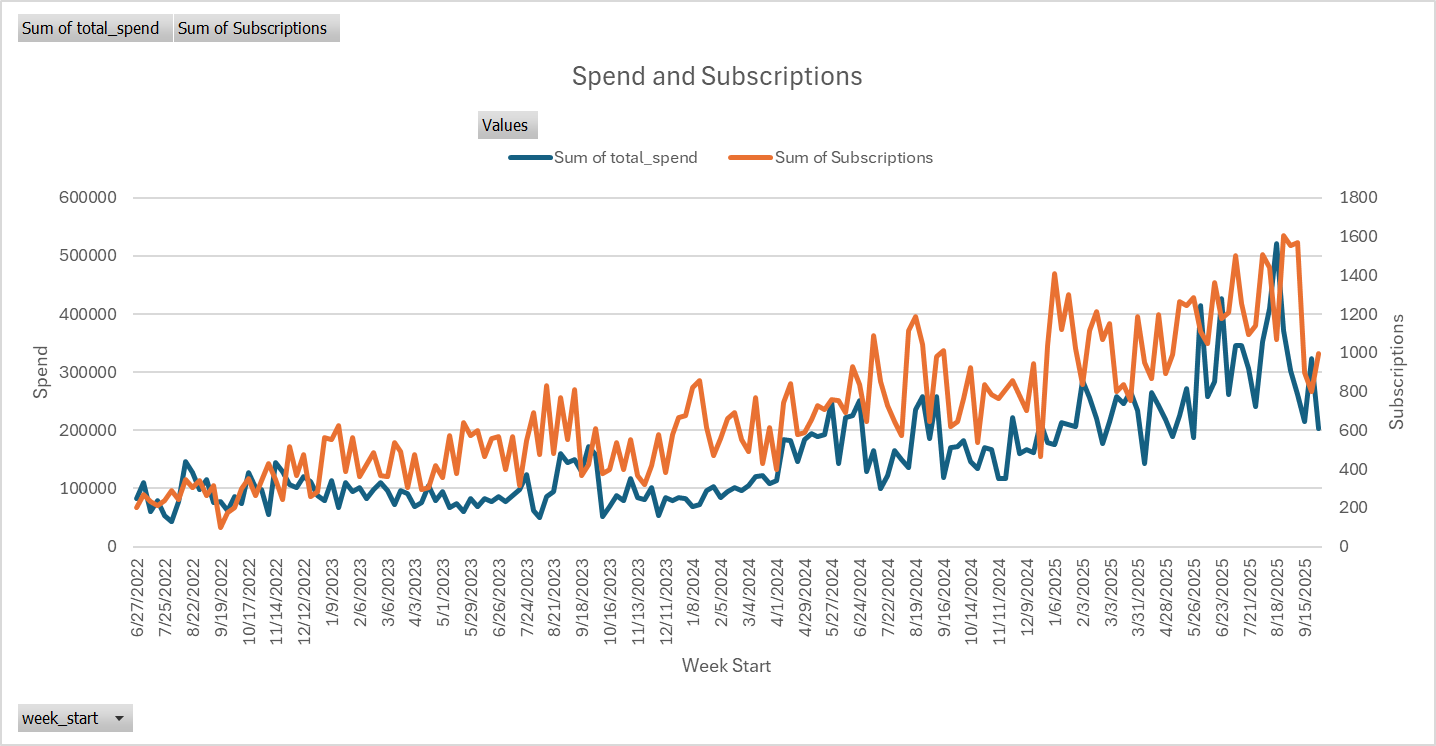

2022, 2023, 2024, 2025 in general following the trend that with increasing spend subscriptions are going up except for late 2024 around 9th December 2024.

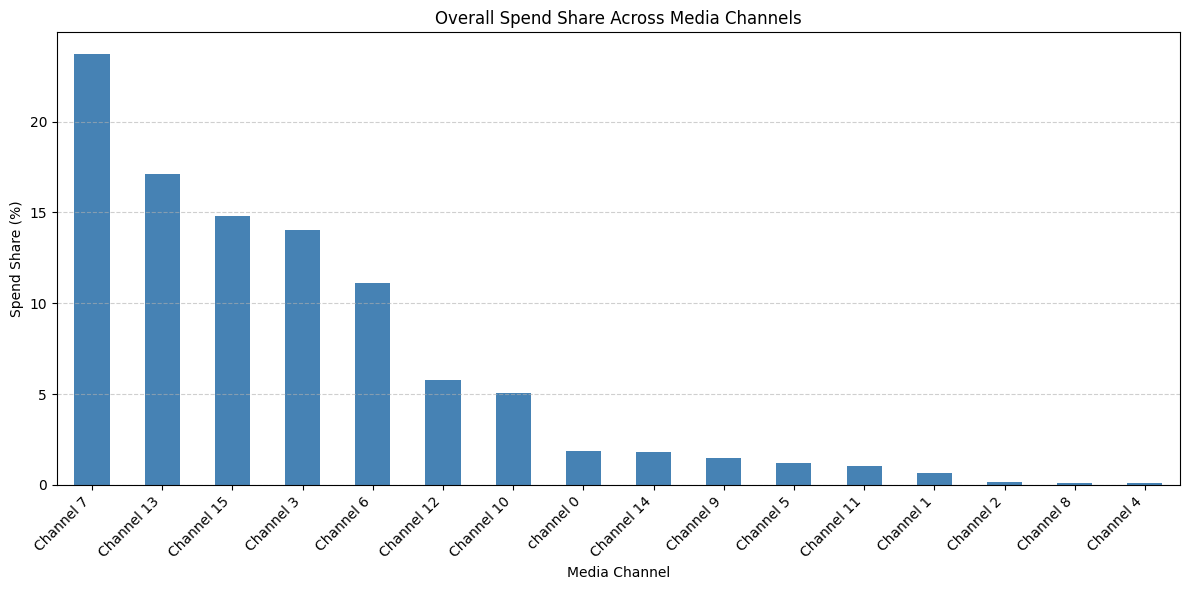

In [19]:

# Identifying spend columns
spend_cols = [c for c in mmm_data.columns if c.endswith('_spend') and c != 'total_spend']

# Computing total spend per channel
total_spend = mmm_data[spend_cols].sum()

# Cleaning up channel names
total_spend.index = total_spend.index.str.replace('_spend', '', regex=False)

# Computing share (%)
spend_share = (total_spend / total_spend.sum() * 100).sort_values(ascending=False)


plt.figure(figsize=(12,6))
spend_share.plot(kind='bar', color='steelblue')
plt.title('Overall Spend Share Across Media Channels')
plt.ylabel('Spend Share (%)')
plt.xlabel('Media Channel')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


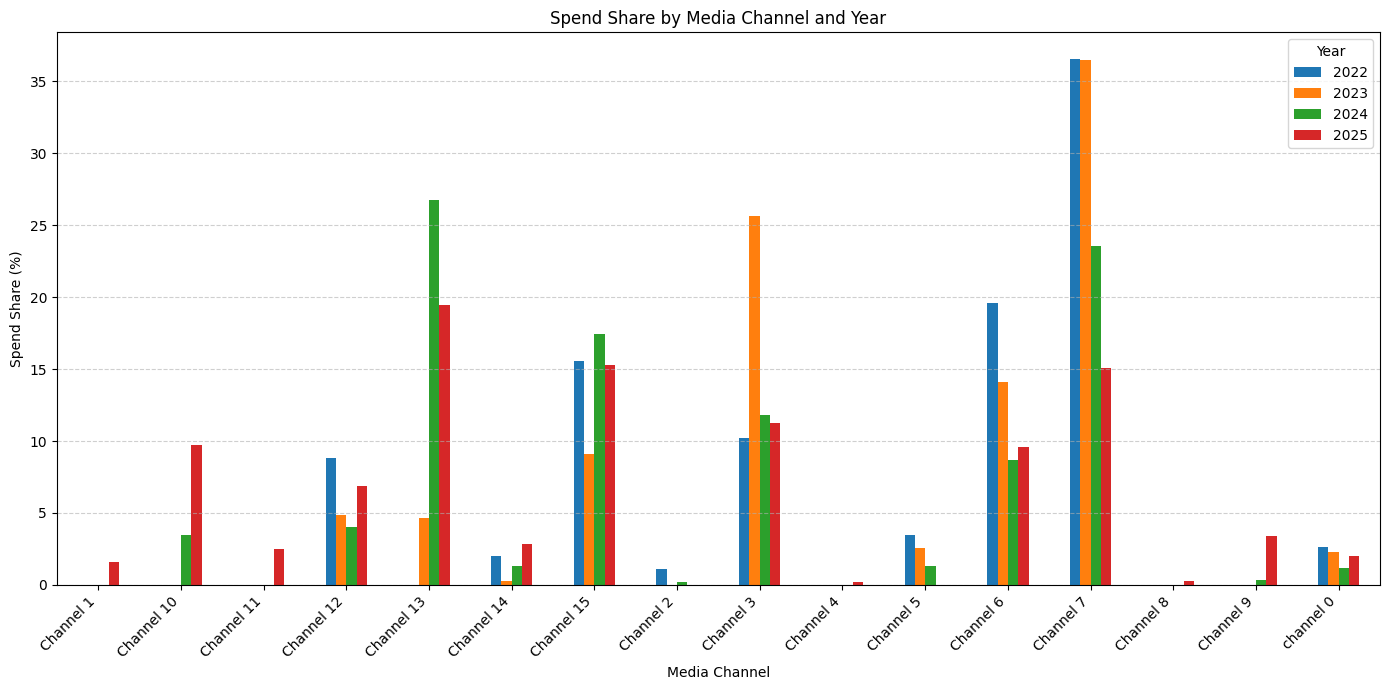

In [20]:
# Melting data for year-level view
df_long = mmm_data.melt(
    id_vars=['year_number'],
    value_vars=spend_cols,
    var_name='media_channel',
    value_name='spend'
)
df_long['media_channel'] = df_long['media_channel'].str.replace('_spend', '', regex=False)

# Grouping by year × channel, sum spend
yearly_spend = (
    df_long.groupby(['year_number', 'media_channel'])['spend']
    .sum()
    .reset_index()
)

# Computing share by year
yearly_spend['spend_share'] = (
    yearly_spend.groupby('year_number')['spend']
    .transform(lambda x: x / x.sum() * 100)
)

# Pivoting for plotting
plot_data = yearly_spend.pivot(
    index='media_channel',
    columns='year_number',
    values='spend_share'
)


plot_data.plot(kind='bar', figsize=(14,7))
plt.title('Spend Share by Media Channel and Year')
plt.ylabel('Spend Share (%)')
plt.xlabel('Media Channel')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Year')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Will check the spend % and coverage to determine which channels can be used as input in the model.

In [21]:

spend_cols = [c for c in mmm_data.columns if c.endswith('_spend') and c != 'total_spend']


total_spend = mmm_data[spend_cols].sum()


total_spend.index = total_spend.index.str.replace('_spend', '', regex=False)


spend_share = (total_spend / total_spend.sum() * 100).sort_values(ascending=False)


spend_share_df = spend_share.reset_index()
spend_share_df.columns = ['media_channel', 'spend_share_pct_2022_to_2025']


spend_share_df


,media_channel,spend_share_pct_2022_to_2025
0,Channel 7,23.733958
1,Channel 13,17.095919
2,Channel 15,14.810650
3,Channel 3,14.018037
4,Channel 6,11.100133
5,Channel 12,5.782131
6,Channel 10,5.058174
7,channel 0,1.869616
8,Channel 14,1.809415
9,Channel 9,1.503869


In [22]:

df_2025 = mmm_data[mmm_data['year_number'] == 2025]


spend_cols = [c for c in df_2025.columns if c.endswith('_spend') and c != 'total_spend']


total_spend = df_2025[spend_cols].sum()


total_spend.index = total_spend.index.str.replace('_spend', '', regex=False)


spend_share = (total_spend / total_spend.sum() * 100).sort_values(ascending=False)


spend_share_df_2025 = spend_share.reset_index()
spend_share_df_2025.columns = ['media_channel', 'spend_share_pct_2025']

spend_share_df_2025


,media_channel,spend_share_pct_2025
0,Channel 13,19.457302
1,Channel 15,15.284406
2,Channel 7,15.076726
3,Channel 3,11.255022
4,Channel 10,9.721378
5,Channel 6,9.597583
6,Channel 12,6.847244
7,Channel 9,3.407402
8,Channel 14,2.843366
9,Channel 11,2.488212


In [23]:
spend_spend_share_df_by_year = spend_share_df.merge(spend_share_df_2025, on = ['media_channel'], how = 'left')

In [24]:
to_merge = media_summary_weeks_active[['media_channel', 'unique_weeks_active']]
spend_spend_share_df_by_year_active = spend_spend_share_df_by_year.merge(to_merge, on = ['media_channel'], how='left')
spend_spend_share_df_by_year_active

,media_channel,spend_share_pct_2022_to_2025,spend_share_pct_2025,unique_weeks_active
0,Channel 7,23.733958,15.076726,170
1,Channel 13,17.095919,19.457302,104
2,Channel 15,14.810650,15.284406,170
3,Channel 3,14.018037,11.255022,171
4,Channel 6,11.100133,9.597583,170
5,Channel 12,5.782131,6.847244,125
6,Channel 10,5.058174,9.721378,62
7,channel 0,1.869616,2.004352,171
8,Channel 14,1.809415,2.843366,93
9,Channel 9,1.503869,3.407402,48


#### The channel spend percentage overall is very similar to the spend pattern in 2025 for the top spending channels with slight variations.
#### From the unique_weeks_active column, we can see the top 8 channels (by index number) have the highest coverage in the dataset.

## Replacing all missing values with 0 as missing values mean there was no spend there. 

In [25]:
# Identify ALL media channel columns
media_cols = [
    c for c in mmm_data.columns 
    if c.endswith('_spend') or c.endswith('_clicks') or c.endswith('_impressions')
]

# Replace NaN with 0 in those columns only
mmm_data[media_cols] = mmm_data[media_cols].fillna(0)


In [26]:
mmm_data

,week_start,week_end,week_number,year_number,partner_count,Promo,Natural Search Visits,competitor_change_flag,channel 0_spend,channel 0_clicks,...,Channel 11_clicks,Channel 11_impressions,Channel 12_spend,Channel 12_clicks,Channel 12_impressions,Channel 13_spend,Channel 13_clicks,Channel 13_impressions,Subscriptions,total_spend
0,6/27/2022,7/3/2022,27,2022,13,0,29985.60969,0,1111.144573,914.198687,...,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,200.164442,83174.968707
1,7/4/2022,7/10/2022,28,2022,15,0,23840.52883,0,1404.464179,2159.410668,...,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,270.896178,110089.013934
2,7/11/2022,7/17/2022,29,2022,12,1,13563.34260,0,2744.381149,2842.643411,...,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,232.538114,60480.664715
3,7/18/2022,7/24/2022,30,2022,12,1,19861.37170,0,3493.213503,2637.664279,...,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,211.083653,79276.889134
4,7/25/2022,7/31/2022,31,2022,15,1,18001.94172,0,3507.389674,2797.310817,...,0.0,0.0,5153.713746,792.720714,1.911834e+04,0.000000,0.000000,0.000000e+00,238.647466,53495.088200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,9/1/2025,9/7/2025,36,2025,30,1,36307.93578,1,10389.694649,5890.396990,...,0.0,0.0,28166.097180,4353.539677,1.204826e+06,21992.566873,-584.609783,9.751352e+05,1554.034974,302553.879077
167,9/8/2025,9/14/2025,37,2025,19,0,34032.04096,1,7323.204534,3630.553165,...,0.0,0.0,20350.098174,4108.119791,8.665761e+05,18110.431148,1410.308144,1.403350e+06,1568.748258,262167.199464
168,9/15/2025,9/21/2025,38,2025,31,1,31364.20146,1,8553.947466,5996.407221,...,0.0,0.0,14876.060515,4108.692262,6.033883e+05,45469.049393,2608.884021,3.792378e+06,900.557577,215624.011895
169,9/22/2025,9/28/2025,39,2025,23,0,19834.82218,1,5389.465949,3445.008225,...,0.0,0.0,19211.046113,6397.868449,1.304002e+06,90457.619187,1872.853694,5.972885e+06,799.702279,323925.091072


## Correlation between channels

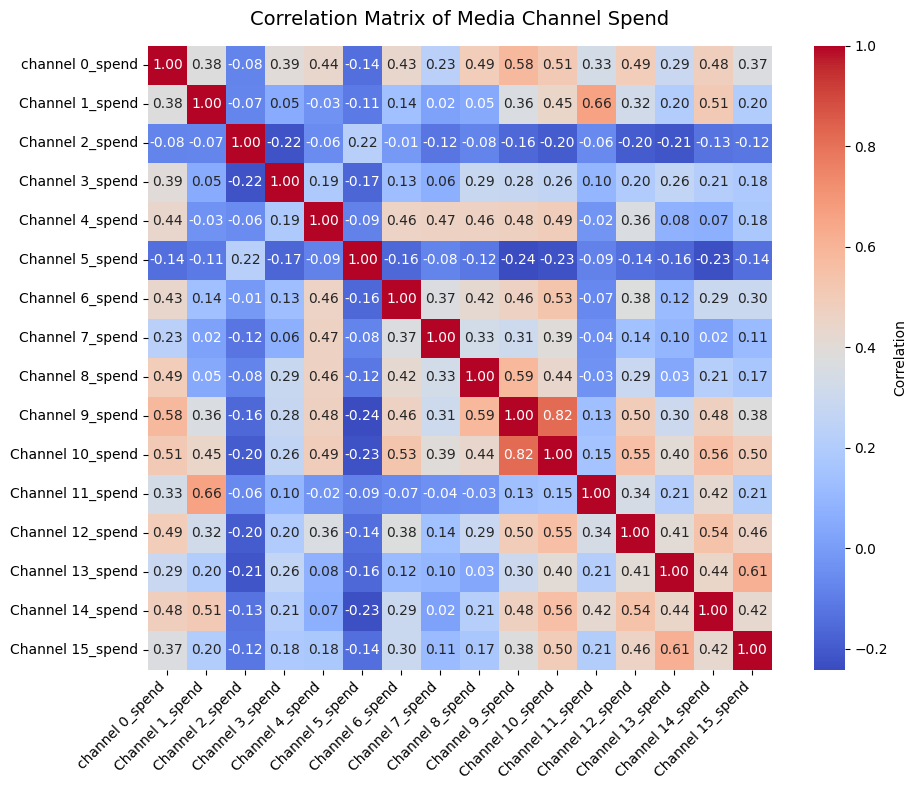

In [27]:

# Channels of interest
channels = [
    'channel 0', 'Channel 1', 'Channel 2', 'Channel 3', 'Channel 4', 'Channel 5', 'Channel 6', 'Channel 7', 'Channel 8', 'Channel 9', 'Channel 10', 'Channel 11', 'Channel 12', 'Channel 13', 'Channel 14', 'Channel 15'

]

# Selecting only spend columns for those channels
spend_cols = [f'{ch}_spend' for ch in channels if f'{ch}_spend' in mmm_data.columns]

# Building correlation matrix
corr_spend = mmm_data[spend_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_spend,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    cbar_kws={'label': 'Correlation'},
    square=True
)
plt.title('Correlation Matrix of Media Channel Spend', fontsize=14, pad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### The correlation matrix tells us -
#### channel 1 and channel 11 are highly correlated.
#### Other noticeable correlation - (channel 10, channel 9). 
#### Meaning as the spending in one channel goes up, the spending in the correlated channel also goes up. it gets harder for the MMM to differentiate which of the 2 correlated contributed to the incremental effect.

In [28]:
channels = [
    'channel 0', 'Channel 1', 'Channel 2', 'Channel 3', 'Channel 4', 'Channel 5', 'Channel 6', 'Channel 7', 'Channel 8', 'Channel 9', 'Channel 10', 'Channel 11', 'Channel 12', 'Channel 13', 'Channel 14', 'Channel 15'
]

spend_cols = [f"{ch}_spend" for ch in channels if f"{ch}_spend" in mmm_data.columns]

X = mmm_data[spend_cols].copy()

# Computing VIF
vif_df = pd.DataFrame()
vif_df['feature'] = X.columns
vif_df['VIF'] = [
    variance_inflation_factor(X.values, i)
    for i in range(len(X.columns))
]
vif_df.sort_values(by='VIF', ascending=False)


,feature,VIF
10,Channel 10_spend,6.775491
0,channel 0_spend,6.550899
6,Channel 6_spend,5.510684
15,Channel 15_spend,5.227308
9,Channel 9_spend,4.932718
3,Channel 3_spend,4.300859
12,Channel 12_spend,4.033766
7,Channel 7_spend,4.025794
14,Channel 14_spend,3.480142
13,Channel 13_spend,3.387572


## Removing the impressions and clicks columns for the media channels as the goal is to track spend in regards to subscriptions.

In [29]:
impression_click_columns_to_drop = [c for c in mmm_data.columns if c.endswith('_impressions') or c.endswith('_clicks')]
mmm_data = mmm_data.drop(impression_click_columns_to_drop, axis = 1)

VIF for the media channels is below 10 meaning there is not much multicolinearity. 

## Analyzing the spend %, coverage, VIF, going to keep the below channels for modeling-
#### 1. Channel 0
#### 2. Channel 3
#### 3. Channel 6
#### 4. Channel 7
#### 5. Channel 9
#### 6. Channel 10
#### 7. Channel 12
#### 8. Channel 13
#### 9. Channel 14
#### 10. Channel 15

In [30]:

channels_to_keep = [
    "channel 0",
    "Channel 3",
    "Channel 6",
    "Channel 7",
    "Channel 9",
    "Channel 10",
    "Channel 12",
    "Channel 13",
    "Channel 14",
    "Channel 15"
]


spend_cols_to_keep = [f"{ch}_spend" for ch in channels_to_keep]


all_spend_cols = [c for c in mmm_data.columns if c.endswith("_spend")]

# identifying the spend columns I dont want
spend_cols_to_drop = [c for c in all_spend_cols if c not in spend_cols_to_keep]

# Final filtered dataframe:
mmm_data_filtered = mmm_data.drop(columns=spend_cols_to_drop)

mmm_data_filtered


,week_start,week_end,week_number,year_number,partner_count,Promo,Natural Search Visits,competitor_change_flag,channel 0_spend,Channel 14_spend,Channel 3_spend,Channel 15_spend,Channel 6_spend,Channel 7_spend,Channel 9_spend,Channel 10_spend,Channel 12_spend,Channel 13_spend,Subscriptions
0,6/27/2022,7/3/2022,27,2022,13,0,29985.60969,0,1111.144573,1774.243165,5974.220364,32926.602486,27807.466802,12234.015385,0.000000,0.000000,0.000000,0.000000,200.164442
1,7/4/2022,7/10/2022,28,2022,15,0,23840.52883,0,1404.464179,5817.086991,13241.295717,20186.001520,23518.138000,43305.798906,0.000000,0.000000,0.000000,0.000000,270.896178
2,7/11/2022,7/17/2022,29,2022,12,1,13563.34260,0,2744.381149,3005.000061,4848.624945,17109.511390,18190.325950,12882.541052,0.000000,0.000000,0.000000,0.000000,232.538114
3,7/18/2022,7/24/2022,30,2022,12,1,19861.37170,0,3493.213503,2103.636901,4264.055469,24322.956580,4081.150901,18703.338647,0.000000,0.000000,0.000000,0.000000,211.083653
4,7/25/2022,7/31/2022,31,2022,15,1,18001.94172,0,3507.389674,0.000000,4362.960291,3549.121942,10996.849154,21550.924570,0.000000,0.000000,5153.713746,0.000000,238.647466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,9/1/2025,9/7/2025,36,2025,30,1,36307.93578,1,10389.694649,3268.539424,42585.660724,34379.760000,60562.245287,56572.388328,13293.683801,25282.749266,28166.097180,21992.566873,1554.034974
167,9/8/2025,9/14/2025,37,2025,19,0,34032.04096,1,7323.204534,4355.950512,48339.157442,30056.199606,53792.262255,37778.786394,8549.283428,28717.060772,20350.098174,18110.431148,1568.748258
168,9/15/2025,9/21/2025,38,2025,31,1,31364.20146,1,8553.947466,4299.617387,27302.938987,39671.203170,7226.720800,34351.025983,8507.231084,24524.977406,14876.060515,45469.049393,900.557577
169,9/22/2025,9/28/2025,39,2025,23,0,19834.82218,1,5389.465949,11005.673136,38716.479320,37814.268530,20065.287024,62514.235068,9427.640100,28477.255222,19211.046113,90457.619187,799.702279


In [31]:
mmm_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   week_start              171 non-null    object 
 1   week_end                171 non-null    object 
 2   week_number             171 non-null    int64  
 3   year_number             171 non-null    int64  
 4   partner_count           171 non-null    int64  
 5   Promo                   171 non-null    int64  
 6   Natural Search Visits   149 non-null    float64
 7   competitor_change_flag  171 non-null    int64  
 8   channel 0_spend         171 non-null    float64
 9   Channel 14_spend        171 non-null    float64
 10  Channel 3_spend         171 non-null    float64
 11  Channel 15_spend        171 non-null    float64
 12  Channel 6_spend         171 non-null    float64
 13  Channel 7_spend         171 non-null    float64
 14  Channel 9_spend         171 non-null    fl

## Getting rid of unnecessary columns
### Meridian requires one time column, can use week_start. Should get rid of week_end, week_number, year_number.

In [32]:
mmm_data_filtered = mmm_data_filtered.drop(
    ['week_end', 'week_number', 'year_number', 'Natural Search Visits'], axis = 1
)

In [33]:
mmm_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   week_start              171 non-null    object 
 1   partner_count           171 non-null    int64  
 2   Promo                   171 non-null    int64  
 3   competitor_change_flag  171 non-null    int64  
 4   channel 0_spend         171 non-null    float64
 5   Channel 14_spend        171 non-null    float64
 6   Channel 3_spend         171 non-null    float64
 7   Channel 15_spend        171 non-null    float64
 8   Channel 6_spend         171 non-null    float64
 9   Channel 7_spend         171 non-null    float64
 10  Channel 9_spend         171 non-null    float64
 11  Channel 10_spend        171 non-null    float64
 12  Channel 12_spend        171 non-null    float64
 13  Channel 13_spend        171 non-null    float64
 14  Subscriptions           171 non-null    fl

## Saving the file as csv to use as model input.

In [ ]:
# file_name = 'model_input2.csv'
# mmm_data_filtered.to_csv(file_name, index = False)
# print('Saved file:', file_name)

Saved file: model_input2.csv
